# Propósito

- Diferenciar imagens do Mickey mouse de um mouse de computador. 

## Caracterização do dado

Para isto, serão baixadas imagens buscadas pelo duck duck go.
Em seguida serão salvas nas pastas: [dataset/mickey](dataset/mickey)
e [dataset/mouse](dataset/mouse). As imagens baixadas podem possuir
largura de no máximo 400px, entretanto para sua 
análise será utilizado o método **squish** para obter imagens de 192px por 192px.

# Testando busca de imagnes

In [28]:
from duckduckgo_search import DDGS
from itertools import islice
from fastcore.all import *

def search_images(term, max_images=30):
    with DDGS() as ddgs:
        vtr = []
        for r in islice(ddgs.images(term + ' jpg'),max_images):
            if r['image'][-3:] == 'jpg':
                vtr.append(r['image'])
        return vtr

In [29]:
urls = search_images('mickey mouse', max_images=1)
urls[0]

'http://www.cartoonbucket.com/wp-content/uploads/2015/04/Standing-Picture-Of-Micky-Mouse.jpg'

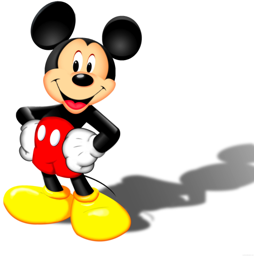

In [31]:
from fastdownload import download_url
dest = 'mickey.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

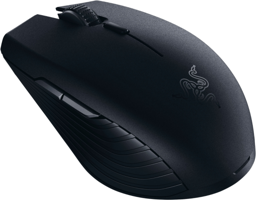

In [32]:
download_url(search_images('mouse razer', max_images=1)[0], 'mouse.jpg', show_progress=False)
Image.open('mouse.jpg').to_thumb(256,256)

In [28]:
## Os códigos a cima geraram duas imagens na pasta atual, esta célula apaga estas imagens. No final do notebook elas serão utilizadas para testar o código.
!rm *.jpg

# Buscando e baixando imagens do dataset

In [33]:
from time import sleep

# Cada elemento de busca é uma tupla que possui um nome para o dataset e uma chave de busca.
searches = [('mickey','Mickey mouse'),('mouse','Mouse gamer')]
images_per_search = 60

path = Path('dataset')

for element in searches:
    dest = (path/element[0])
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{element[1]}', images_per_search))

    resize_images(path/element[0], max_size=400, dest=path/element[0])

In [39]:
# Código para limpar o dataset, caso necessário.
!rm -rf dataset/*

4029.73s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [34]:
# Buscando por imagens que deram erro durante o download e removendo-as
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

# Treinando o modelo

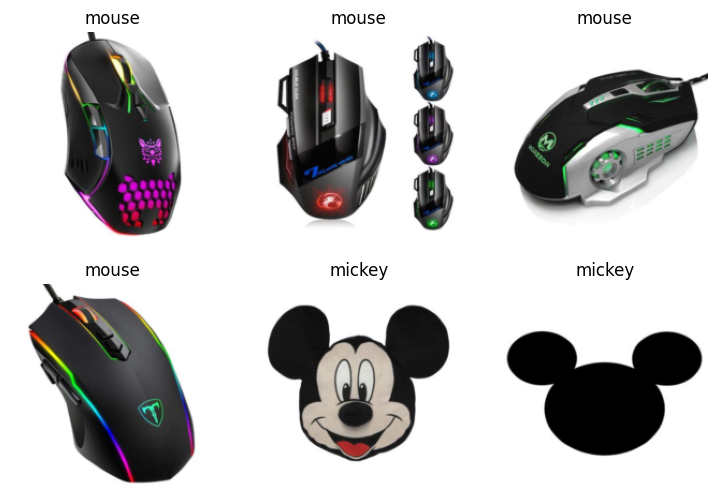

In [35]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [36]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/home/hellsank/projetos/FastaiFGA/nbs/lesson01/env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hellsank/projetos/FastaiFGA/nbs/lesson01/env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.207211,0.376364,0.102564,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.057596,0.141780,0.025641,00:10
1,0.034940,0.045261,0.025641,00:10
2,0.022562,0.020048,0.000000,00:09


# Testando o modelo

## O Mickey é o Mickey ?

In [37]:
is_mickey ,_,probs = learn.predict(PILImage.create('mickey.jpg'))
print(f"This is a: {is_mickey}.")
print(f"Probability it's mickey: {probs[0]:.4f}")

This is a: mickey.
Probability it's mickey: 1.0000


## O Mouse é o Mickey ?

In [38]:
is_mickey ,_,probs = learn.predict(PILImage.create('mouse.jpg'))
print(f"This is a: {is_mickey}.")
print(f"Probability it's mickey: {probs[0]:.4f}")

This is a: mouse.
Probability it's mickey: 0.0001


## Um Mouse com a imagem do Mickey é o que ?

In [39]:
is_mickey ,_,probs = learn.predict(PILImage.create('mickey_mouse_mouse.jpg'))
print(f"This is a: {is_mickey}.")
print(f"Probability it's mickey: {probs[0]:.4f}")

This is a: mickey.
Probability it's mickey: 0.5611


# Nem o mouse nem o mickey, mas 56% de chance de ser o mickey

![mickey mouse mouse](mickey_mouse_mouse.jpg)